<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-3-Jenis-Beras/blob/master/Klasifikasi%20Jenis%20Beras%20MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi 3 Jenis Beras**

# Mengambil *Dataset* dari *Github*

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/data > /dev/null

## Persiapan

Program ini dibuat untuk membedakan 3 jenis beras yaitu :

1.   Jenis Beras IR 64
2.   Jenis Beras Cilamaya
3.   Jenis Beras Ketan

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi *Library*

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

TensorFlow 2.x selected.


## Mengimpor Dataset

In [0]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Cilamaya
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  test.txt	train  train.txt
Cilamaya  IR64	Ketan
C10.jpg  C19.jpg  C27.jpg  C35.jpg  C43.jpg  C51.jpg  C5.jpg   C68.jpg	C7.jpg
C11.jpg  C1.jpg   C28.jpg  C36.jpg  C44.jpg  C52.jpg  C60.jpg  C69.jpg	C8.jpg
C12.jpg  C20.jpg  C29.jpg  C37.jpg  C45.jpg  C53.jpg  C61.jpg  C6.jpg	C9.jpg
C13.jpg  C21.jpg  C2.jpg   C38.jpg  C46.jpg  C54.jpg  C62.jpg  C70.jpg
C14.jpg  C22.jpg  C30.jpg  C39.jpg  C47.jpg  C55.jpg  C63.jpg  C71.jpg
C15.jpg  C23.jpg  C31.jpg  C3.jpg   C48.jpg  C56.jpg  C64.jpg  C72.jpg
C16.jpg  C24.jpg  C32.jpg  C40.jpg  C49.jpg  C57.jpg  C65.jpg  C73.jpg
C17.jpg  C25.jpg  C33.jpg  C41.jpg  C4.jpg   C58.jpg  C66.jpg  C74.jpg
C18.jpg  C26.jpg  C34.jpg  C42.jpg  C50.jpg  C59.jpg  C67.jpg  C75.jpg
I10.jpg  I19.jpg  I27.jpg  I35.jpg  I43.jpg  I51.jpg  I5.jpg   I68.jpg	I7.jpg
I11.jpg  I1.jpg   I28.jpg  I36.jpg  I44.jpg  I52.jpg  I60.jpg  I69.jpg	I8.jpg
I12.jpg  I20.jpg  I29.jpg  I37.jpg  I45.jpg  I53.jpg  I61.jpg  I6.jpg	I9.jpg
I13.jpg  I21.jpg  I2.jpg   I38.jpg  I46.jpg  I54.jpg  I

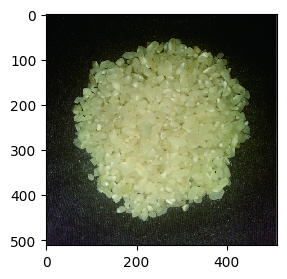

In [0]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/Cilamaya/C17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [0]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 64
base_dir = os.path.join('data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (64, 224, 224, 3) (64, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (46, 224, 224, 3) (46,)


## Menyimpan Label

In [0]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Cilamaya': 0, 'IR64': 1, 'Ketan': 2}


In [0]:
!cat labels.txt

Cilamaya
IR64
Ketan

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [0]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [0]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [0]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


## Pelatihan

In [0]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/100
3/3 [==============================] - 6s 2s/step - loss: 2.5558 - acc: 0.4556 - val_loss: 1.3056 - val_acc: 0.4222
Epoch 2/100
3/3 [==============================] - 2s 612ms/step - loss: 1.2373 - acc: 0.6278 - val_loss: 1.3580 - val_acc: 0.4889
Epoch 3/100
3/3 [==============================] - 2s 603ms/step - loss: 0.7294 - acc: 0.7778 - val_loss: 1.3961 - val_acc: 0.4222
Epoch 4/100
3/3 [==============================] - 2s 647ms/step - loss: 0.4458 - acc: 0.8944 - val_loss: 0.9759 - val_acc: 0.4444
Epoch 5/100
3/3 [==============================] - 2s 584ms/step - loss: 0.4414 - acc: 0.8444 - val_loss: 0.9430 - val_acc: 0.6444
Epoch 6/100
3/3 [==============================] - 2s 631ms/step - loss: 0.1768 - acc: 0.9556 - val_loss: 1.6167 - val_acc: 0.6222
Epoch 7/100
3/3 [==============================] - 2s 628ms/step - loss: 0.1532 - acc: 0.9500 - val_loss: 1.2230 - val_acc: 0.4889
Epoch 8/100
3/3 [==============================] - 2s 598ms/step - loss: 0.0774 - acc:

## Menggambarkan Hasil Pelatihan

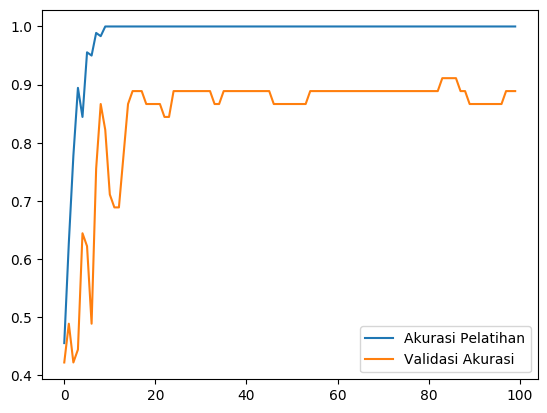

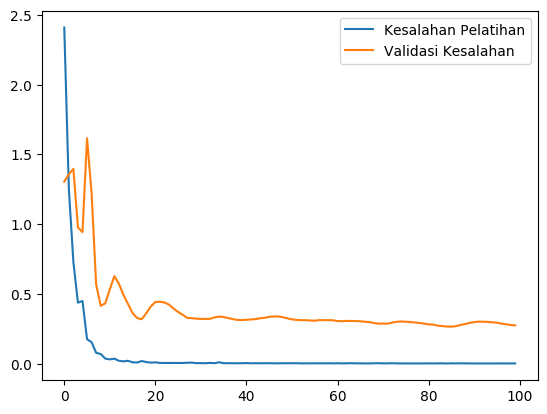

In [0]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [0]:
print(train_generator)

In [0]:
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", image_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [[[0.12941177 0.14117648 0.13725491]
  [0.01568628 0.02352941 0.02352941]
  [0.01176471 0.01960784 0.01568628]
  ...
  [0.01568628 0.02745098 0.02352941]
  [0.01568628 0.02745098 0.02352941]
  [0.01960784 0.03137255 0.02745098]]

 [[0.1137255  0.1254902  0.12156864]
  [0.00784314 0.01568628 0.01568628]
  [0.01176471 0.01960784 0.01960784]
  ...
  [0.01568628 0.02352941 0.01960784]
  [0.01568628 0.03137255 0.02745098]
  [0.01176471 0.02352941 0.01960784]]

 [[0.1254902  0.14117648 0.13333334]
  [0.01176471 0.02352941 0.01960784]
  [0.00784314 0.01568628 0.01176471]
  ...
  [0.01568628 0.01960784 0.01960784]
  [0.01176471 0.01960784 0.01960784]
  [0.01960784 0.02745098 0.02352941]]

 ...

 [[0.12156864 0.12941177 0.13725491]
  [0.07058824 0.08235294 0.07058824]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.02745098 0.02745098]
  [0.02745098 0.03137255 0.03529412]]

 [[0.12156864 0.1254902  0.13333334]
  [0.0509804  0.058

Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Cilamaya, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [0]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
3/3 [==============================] - 2s 794ms/step - loss: 0.5446 - acc: 0.7556
[0.5445805390675863, 0.75555557]
1/1 [==============================] - 1s 518ms/step - loss: 0.2738 - acc: 0.8889
[0.2738253176212311, 0.8888889]
46/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
[2 0 0 0 0 0 0 2 2 1 2 0 0 0 0 0 1 1 1 1 2 2 2 2 1 2 2 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


## Prediksi Gambar Individual

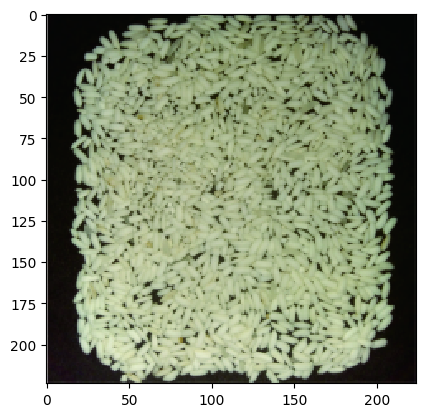

Label yang benar adalah: 2 : l
Nilai yang diprediksi adalah: [2.1366819e-05 7.0334082e-03 9.9294525e-01]
Label yang diprediksi adalah: 2 : l
Prediksi benar


In [0]:
n = 45 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [0]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/model/assets
